# Faster R-CNN Training Script - Production Version

Training script with robust error handling and validation for parking dataset.

This notebook provides a complete training pipeline for Faster R-CNN object detection.

## 1. Imports and Setup

In [1]:
import os
import sys
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import json
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import argparse
import warnings
warnings.filterwarnings('ignore')

# Check PyTorch version for compatibility
TORCH_VERSION = tuple(int(x) for x in torch.__version__.split('.')[:2])
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 2070


## 2. Dataset Class

Custom dataset for loading COCO format annotations with validation.

In [2]:
class COCODataset(torch.utils.data.Dataset):
    """
    Custom dataset for loading COCO format annotations.
    Handles transforms and validates all data during initialization.
    """
    def __init__(self, json_file, img_dir, transforms=None):
        from pycocotools.coco import COCO
        
        self.img_dir = Path(img_dir)
        self.transforms = transforms
        
        # Load COCO annotations
        print(f"Loading annotations from {json_file}...")
        try:
            self.coco = COCO(str(json_file))
        except Exception as e:
            print(f"Error: Failed to load COCO file: {e}")
            raise
        
        self.ids = list(sorted(self.coco.imgs.keys()))
        
        # Validate dataset
        self._validate_dataset()
        
        print(f"Loaded {len(self.ids)} images from {json_file}")
    
    def _validate_dataset(self):
        """Validate dataset integrity"""
        total_boxes = 0
        images_without_boxes = 0
        images_with_invalid_boxes = 0
        
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            
            if len(anns) == 0:
                images_without_boxes += 1
                continue
            
            # Check for invalid boxes
            valid_boxes = 0
            for ann in anns:
                x, y, w, h = ann['bbox']
                if w > 0 and h > 0:
                    valid_boxes += 1
            
            if valid_boxes == 0:
                images_with_invalid_boxes += 1
            
            total_boxes += valid_boxes
        
        if images_without_boxes > 0:
            print(f"   Warning: {images_without_boxes} images have no annotations")
        
        if images_with_invalid_boxes > 0:
            print(f"   Warning: {images_with_invalid_boxes} images have only invalid boxes")
        
        valid_images = len(self.ids) - images_without_boxes - images_with_invalid_boxes
        
        print(f"   Valid images: {valid_images}")
        print(f"   Total annotations: {total_boxes}")
        print(f"   Avg boxes/image: {total_boxes/len(self.ids):.2f}")
        
        if valid_images == 0:
            raise ValueError("No valid images found in dataset!")
    
    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_anns = self.coco.loadAnns(ann_ids)
        
        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir / img_info['file_name']
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Failed to load image {img_path}: {e}")
            # Return a dummy sample
            img = Image.new('RGB', (640, 480))
            coco_anns = []
        
        # Parse annotations
        boxes, labels, areas = [], [], []
        for ann in coco_anns:
            x, y, w, h = ann['bbox']
            
            # Skip invalid boxes
            if w <= 0 or h <= 0:
                continue
            
            # COCO bbox is [x, y, width, height]
            # PyTorch needs [x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            areas.append(ann['area'])
        
        # Convert to tensors
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
        else:
            # Empty annotations
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            areas = torch.zeros(0, dtype=torch.float32)
        
        image_id = torch.tensor([img_id])
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": areas,
            "iscrowd": torch.zeros(len(boxes), dtype=torch.int64)
        }
        
        # Apply transforms
        if self.transforms:
            img = self.transforms(img)
        
        return img, target
    
    def __len__(self):
        return len(self.ids)

## 3. Data Transforms

Simple transforms that work with detection models - normalization using ImageNet statistics.

In [3]:
def get_transform(train=False):
    """
    Create image transforms for the model.
    Simple transforms that work with detection models.
    Only normalizes the image - augmentations handled by model.
    """
    transforms = []
    
    # Convert PIL to Tensor
    transforms.append(torchvision.transforms.ToTensor())
    
    # Normalize using ImageNet stats
    transforms.append(torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ))
    
    return torchvision.transforms.Compose(transforms)

## 4. Model Creation

Create Faster R-CNN model with ResNet-50 FPN backbone and custom anchors.

In [4]:
def get_model(num_classes, anchor_sizes=None, pretrained=True):
    """
    Create Faster R-CNN model with custom anchors
    
    Args:
        num_classes: Number of classes (including background)
        anchor_sizes: Tuple of anchor sizes, e.g., ((8,), (16,), (32,), (64,), (128,))
        pretrained: Use pretrained backbone
    """
    print("\n" + "="*70)
    print("Creating Model")
    print("="*70)
    
    # Load pretrained ResNet-50 FPN backbone
    if pretrained:
        try:
            weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)
            print("Loaded pretrained weights (FasterRCNN_ResNet50_FPN_V2)")
        except AttributeError:
            # Fallback for older torchvision versions
            weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
            print("Loaded pretrained weights (FasterRCNN_ResNet50_FPN)")
    else:
        try:
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
        except AttributeError:
            model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        print("Initialized model from scratch (NOT recommended)")
    
    # Custom anchor generator if provided
    if anchor_sizes is not None:
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(
            sizes=anchor_sizes,
            aspect_ratios=aspect_ratios
        )
        model.rpn.anchor_generator = anchor_generator
        print(f"Custom RPN anchors: {anchor_sizes}")
        print(f"  Aspect ratios: {aspect_ratios[0]}")
    else:
        print(f"Using default anchors")
    
    # Replace box predictor head for our number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print(f"Replaced box predictor for {num_classes} classes")
    
    return model

## 5. Collate Function

Custom collate function for batching variable-sized images and annotations.

In [5]:
def collate_fn(batch):
    """
    Custom collate function for batching
    Handles variable-sized images and annotations
    """
    return tuple(zip(*batch))

## 6. Training Function

Train for one epoch with error handling, gradient clipping, and optional mixed precision.

In [6]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None):
    """
    Train for one epoch with proper error handling
    """
    model.train()
    
    total_loss = 0.0
    loss_dict_cumulative = {}
    num_batches = 0
    num_skipped = 0
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch} [Train]", 
                leave=True, ncols=100, file=sys.stdout)
    
    for images, targets in pbar:
        try:
            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Filter out images with no boxes to prevent training errors
            valid_idx = [i for i, t in enumerate(targets) if len(t['boxes']) > 0]
            if len(valid_idx) == 0:
                num_skipped += 1
                continue
            
            images = [images[i] for i in valid_idx]
            targets = [targets[i] for i in valid_idx]
            
            # Forward pass
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                
                # Check for NaN
                if torch.isnan(losses) or torch.isinf(losses):
                    print(f"\nWarning: NaN/Inf loss detected, skipping batch")
                    num_skipped += 1
                    continue
                
                # Backward pass with gradient scaling
                optimizer.zero_grad()
                scaler.scale(losses).backward()
                
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Check for NaN
                if torch.isnan(losses) or torch.isinf(losses):
                    print(f"\nWarning: NaN/Inf loss detected, skipping batch")
                    num_skipped += 1
                    continue
                
                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                
                optimizer.step()
            
            # Accumulate losses (detach from graph)
            total_loss += losses.item()
            for k, v in loss_dict.items():
                if k not in loss_dict_cumulative:
                    loss_dict_cumulative[k] = 0.0
                loss_dict_cumulative[k] += v.item()
            
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{losses.item():.4f}",
                'avg': f"{total_loss/num_batches:.4f}",
                'skip': num_skipped
            })
            
        except RuntimeError as e:
            print(f"\nWarning: Runtime error in batch: {e}")
            num_skipped += 1
            continue
    
    avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    
    # Print detailed loss breakdown
    if num_batches > 0:
        print(f"\n  Loss breakdown:")
        for k, v in loss_dict_cumulative.items():
            print(f"    {k}: {v/num_batches:.4f}")
    
    if num_skipped > 0:
        print(f"  Warning: Skipped {num_skipped} batches due to errors")
    
    return avg_loss

## 7. Evaluation Function

Evaluate using official COCO metrics (mAP, AP@50, AP@75).

In [7]:
@torch.no_grad()
def evaluate(model, data_loader, device, coco_gt):
    """
    Evaluate using official COCO metrics with error handling
    """
    from pycocotools.cocoeval import COCOeval
    
    model.eval()
    
    coco_results = []
    num_errors = 0
    
    pbar = tqdm(data_loader, desc="Evaluating")
    
    for images, targets in pbar:
        try:
            images = [img.to(device) for img in images]
            
            outputs = model(images)
            
            # Convert to COCO format
            for target, output in zip(targets, outputs):
                image_id = target['image_id'].item()
                
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                
                # Filter by score threshold
                score_threshold = 0.05  # Low threshold for evaluation
                mask = scores > score_threshold
                
                boxes = boxes[mask]
                scores = scores[mask]
                labels = labels[mask]
                
                for box, score, label in zip(boxes, scores, labels):
                    # Convert [x1, y1, x2, y2] to [x, y, w, h]
                    x1, y1, x2, y2 = box
                    w = x2 - x1
                    h = y2 - y1
                    
                    # Skip invalid predictions
                    if w <= 0 or h <= 0:
                        continue
                    
                    coco_results.append({
                        'image_id': int(image_id),
                        'category_id': int(label),
                        'bbox': [float(x1), float(y1), float(w), float(h)],
                        'score': float(score)
                    })
        
        except Exception as e:
            num_errors += 1
            pbar.set_postfix({'errors': num_errors})
            continue
    
    # Evaluate with COCO API
    if len(coco_results) == 0:
        print("\nWarning: No predictions made!")
        return 0.0, 0.0, 0.0
    
    try:
        coco_dt = coco_gt.loadRes(coco_results)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        
        # Extract key metrics
        map_50_95 = coco_eval.stats[0]  # AP @ IoU=0.50:0.95
        ap50 = coco_eval.stats[1]       # AP @ IoU=0.50
        ap75 = coco_eval.stats[2]       # AP @ IoU=0.75
        
        return map_50_95, ap50, ap75
        
    except Exception as e:
        print(f"\nWarning: COCO evaluation failed: {e}")
        print(f"    Generated {len(coco_results)} predictions")
        return 0.0, 0.0, 0.0

## 8. Checkpoint Management

Save model checkpoints with all necessary information.

In [8]:
def save_checkpoint(model, optimizer, scheduler, epoch, metrics, output_dir, filename):
    """Save checkpoint with all necessary information"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics,
        'torch_version': torch.__version__,
        'torchvision_version': torchvision.__version__,
    }
    
    save_path = output_dir / filename
    torch.save(checkpoint, save_path)
    return save_path

## 9. Configuration

Set your training parameters here.

In [9]:
# Training Configuration
config = {
    # Data
    'data_dir': '../yolo/prepared_data/coco',
    'output_dir': './runs/rcnn',
    
    # Model
    'num_classes': 2,  # Background + car
    'pretrained': True,
    'anchor_sizes': None,  # e.g., ((8,), (16,), (32,), (64,), (128,)) or None for default
    
    # Training
    'epochs': 50,
    'batch_size': 6, 
    'num_workers': 0,
    
    # Optimizer
    'optimizer': 'sgd',  # 'sgd' or 'adamw'
    'lr': 0.001,
    'weight_decay': 0.0005,
    
    # Scheduler
    'scheduler': 'step',  # 'step', 'cosine', or 'multistep'
    'lr_step_size': 15,
    'lr_gamma': 0.1,
    
    # Other
    'patience': 15,  # Early stopping patience
    'amp': True,  # Automatic mixed precision
}

print("Training Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Training Configuration:
  data_dir: ../yolo/prepared_data/coco
  output_dir: ./runs/rcnn
  num_classes: 2
  pretrained: True
  anchor_sizes: None
  epochs: 50
  batch_size: 6
  num_workers: 0
  optimizer: sgd
  lr: 0.001
  weight_decay: 0.0005
  scheduler: step
  lr_step_size: 15
  lr_gamma: 0.1
  patience: 15
  amp: True


## 10. Device Setup

Setup device (GPU or CPU) and create output directory.

In [10]:
print("="*70)
print("Faster R-CNN Training - Production Version")
print("="*70)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")

# Create output directory
output_dir = Path(config['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)

# Save configuration
with open(output_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"\nOutput directory: {output_dir.absolute()}")

Faster R-CNN Training - Production Version

Device: cuda
   GPU: NVIDIA GeForce RTX 2070
   Memory: 8.59 GB
   CUDA Version: 12.1

Output directory: c:\Users\justi\Documents\parking_analyzer\parking_analyzer\rcnn\runs\rcnn


## 11. Load Datasets

Load training and validation datasets.

In [11]:
print("\nLoading Datasets")
print("="*70)

data_path = Path(config['data_dir'])

# Verify data exists
if not (data_path / 'train.json').exists():
    raise FileNotFoundError(f"Training data not found at {data_path / 'train.json'}")

if not (data_path / 'val.json').exists():
    raise FileNotFoundError(f"Validation data not found at {data_path / 'val.json'}")

# Load datasets
train_dataset = COCODataset(
    json_file=data_path / 'train.json',
    img_dir=data_path / 'train',
    transforms=get_transform(train=True)
)

val_dataset = COCODataset(
    json_file=data_path / 'val.json',
    img_dir=data_path / 'val',
    transforms=get_transform(train=False)
)


Loading Datasets
Loading annotations from ..\yolo\prepared_data\coco\train.json...
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
   Valid images: 692
   Total annotations: 29493
   Avg boxes/image: 42.62
Loaded 692 images from ..\yolo\prepared_data\coco\train.json
Loading annotations from ..\yolo\prepared_data\coco\val.json...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
   Valid images: 148
   Total annotations: 6422
   Avg boxes/image: 43.39
Loaded 148 images from ..\yolo\prepared_data\coco\val.json


## 12. Create DataLoaders

Create training and validation data loaders.

In [12]:
# Data loaders with persistent_workers compatibility check
use_persistent_workers = config['num_workers'] > 0 and TORCH_VERSION >= (1, 7)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=use_persistent_workers
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=use_persistent_workers
)

print(f"\nDataLoaders created:")
print(f"  Workers: {config['num_workers']}")
print(f"  Persistent workers: {use_persistent_workers}")
print(f"  Batch size: {config['batch_size']}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


DataLoaders created:
  Workers: 0
  Persistent workers: False
  Batch size: 6
  Training batches: 116
  Validation batches: 25


## 13. Create Model

Initialize the Faster R-CNN model.

In [13]:
# Create model
model = get_model(
    num_classes=config['num_classes'],
    anchor_sizes=config['anchor_sizes'],
    pretrained=config['pretrained']
)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")


Creating Model
Loaded pretrained weights (FasterRCNN_ResNet50_FPN_V2)
Using default anchors
Replaced box predictor for 2 classes

Model Parameters:
  Total: 43,256,153
  Trainable: 43,030,809


## 14. Setup Optimizer and Scheduler

Configure optimizer and learning rate scheduler.

In [14]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]

if config['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(
        params,
        lr=config['lr'],
        momentum=0.9,
        weight_decay=config['weight_decay']
    )
    print(f"\nUsing SGD optimizer")
else:
    optimizer = torch.optim.AdamW(
        params,
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )
    print(f"\nUsing AdamW optimizer")

print(f"  Learning rate: {config['lr']}")
print(f"  Weight decay: {config['weight_decay']}")

# Learning rate scheduler
if config['scheduler'] == 'step':
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=config['lr_step_size'],
        gamma=config['lr_gamma']
    )
    print(f"Using StepLR scheduler")
    print(f"  Step size: {config['lr_step_size']}")
    print(f"  Gamma: {config['lr_gamma']}")
elif config['scheduler'] == 'cosine':
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['epochs'],
        eta_min=1e-6
    )
    print(f"Using CosineAnnealingLR scheduler")
else:  # multistep
    milestones = [int(config['epochs'] * 0.6), int(config['epochs'] * 0.8)]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=milestones,
        gamma=0.1
    )
    print(f"Using MultiStepLR scheduler")
    print(f"  Milestones: {milestones}")

# Mixed precision training with proper compatibility check
scaler = None
if config['amp'] and torch.cuda.is_available():
    if hasattr(torch.cuda.amp, 'GradScaler'):
        scaler = torch.cuda.amp.GradScaler()
        print("Using mixed precision training (AMP)")
    else:
        print("Warning: AMP not available in this PyTorch version")


Using SGD optimizer
  Learning rate: 0.001
  Weight decay: 0.0005
Using StepLR scheduler
  Step size: 15
  Gamma: 0.1
Using mixed precision training (AMP)


## 15. Training Loop

Main training loop with validation and checkpointing.

In [15]:
import torch

torch.cuda.empty_cache()

if torch.cuda.is_available():
    free_memory = torch.cuda.mem_get_info()[0] / 1e9
    total_memory = torch.cuda.mem_get_info()[1] / 1e9
    print(f"GPU Memory: {free_memory:.2f} GB free / {total_memory:.2f} GB total")
    
    if free_memory < 6.0:
        print(f"\n⚠️ WARNING: Only {free_memory:.2f} GB free!")
        print("You need to restart the kernel to clear memory.")
        print("Go to: Kernel → Restart Kernel")
    else:
        print(f"\n✓ GPU memory is clear! Ready to train.")

GPU Memory: 7.31 GB free / 8.59 GB total

✓ GPU memory is clear! Ready to train.


In [16]:
## 15. Training Loop (WITH AGGRESSIVE MEMORY MANAGEMENT)

print("\n" + "="*70)
print("Training")
print("="*70)

import sys
import time
import gc

best_map = 0.0
best_ap50 = 0.0
best_ap75 = 0.0
epochs_no_improve = 0

history = {
    'train_loss': [],
    'val_map': [],
    'val_ap50': [],
    'val_ap75': [],
    'lr': []
}

start_time = time.time()

try:
    for epoch in range(1, config['epochs'] + 1):
        epoch_start = time.time()
        
        print(f"\n{'='*70}")
        print(f"Epoch {epoch}/{config['epochs']}")
        print(f"{'='*70}")
        
        # Clear memory before epoch
        torch.cuda.empty_cache()
        gc.collect()
        
        # TRAINING
        model.train()
        total_loss = 0.0
        loss_dict_cumulative = {}
        num_batches = 0
        num_skipped = 0
        
        print(f"Training - Total batches: {len(train_loader)}")
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            batch_start = time.time()
            
            try:
                # Move to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Filter valid samples
                valid_idx = [i for i, t in enumerate(targets) if len(t['boxes']) > 0]
                if len(valid_idx) == 0:
                    num_skipped += 1
                    continue
                
                images = [images[i] for i in valid_idx]
                targets = [targets[i] for i in valid_idx]
                
                # Forward + Backward with AMP
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        loss_dict = model(images, targets)
                        losses = sum(loss for loss in loss_dict.values())
                    
                    if torch.isnan(losses) or torch.isinf(losses):
                        num_skipped += 1
                        torch.cuda.empty_cache()
                        continue
                    
                    optimizer.zero_grad()
                    scaler.scale(losses).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    
                    if torch.isnan(losses) or torch.isinf(losses):
                        num_skipped += 1
                        torch.cuda.empty_cache()
                        continue
                    
                    optimizer.zero_grad()
                    losses.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
                    optimizer.step()
                
                # Accumulate
                total_loss += losses.item()
                for k, v in loss_dict.items():
                    if k not in loss_dict_cumulative:
                        loss_dict_cumulative[k] = 0.0
                    loss_dict_cumulative[k] += v.item()
                
                num_batches += 1
                batch_time = time.time() - batch_start
                
                # CRITICAL: Clear memory after each batch
                del images, targets, loss_dict, losses
                torch.cuda.empty_cache()
                
                # Print every 10 batches
                if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
                    progress = (batch_idx + 1) / len(train_loader) * 100
                    avg_loss = total_loss / num_batches
                    eta_seconds = batch_time * (len(train_loader) - batch_idx - 1)
                    eta_minutes = eta_seconds / 60
                    
                    # Check memory
                    mem_allocated = torch.cuda.memory_allocated(0) / 1e9
                    mem_reserved = torch.cuda.memory_reserved(0) / 1e9
                    
                    print(f"  [{progress:5.1f}%] Batch {batch_idx+1:3d}/{len(train_loader)} | "
                          f"Loss: {total_loss/num_batches:.4f} | "
                          f"Time: {batch_time:.1f}s | ETA: {eta_minutes:.1f}min | "
                          f"GPU: {mem_allocated:.1f}GB | Skip: {num_skipped}", flush=True)
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"  OOM at batch {batch_idx} - clearing cache", flush=True)
                    
                    # Aggressive cleanup
                    del images, targets
                    if 'loss_dict' in locals():
                        del loss_dict
                    if 'losses' in locals():
                        del losses
                    
                    torch.cuda.empty_cache()
                    gc.collect()
                    
                    num_skipped += 1
                    continue
                else:
                    print(f"  ERROR at batch {batch_idx}: {e}", flush=True)
                    num_skipped += 1
                    continue
        
        train_loss = total_loss / num_batches if num_batches > 0 else float('inf')
        
        # Loss breakdown
        print(f"\n  Loss breakdown:")
        for k, v in loss_dict_cumulative.items():
            print(f"    {k}: {v/num_batches:.4f}")
        
        if num_skipped > 0:
            print(f"  Skipped batches: {num_skipped}")
        
        # Clear memory before evaluation
        torch.cuda.empty_cache()
        gc.collect()
        
        # Update LR
        lr_scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # EVALUATION
        print(f"\n  Evaluating...")
        
        from pycocotools.cocoeval import COCOeval
        model.eval()
        coco_results = []
        
        with torch.no_grad():
            for eval_idx, (images, targets) in enumerate(val_loader):
                try:
                    images = [img.to(device) for img in images]
                    outputs = model(images)
                    
                    for target, output in zip(targets, outputs):
                        image_id = target['image_id'].item()
                        boxes = output['boxes'].cpu().numpy()
                        scores = output['scores'].cpu().numpy()
                        labels = output['labels'].cpu().numpy()
                        
                        mask = scores > 0.05
                        boxes, scores, labels = boxes[mask], scores[mask], labels[mask]
                        
                        for box, score, label in zip(boxes, scores, labels):
                            x1, y1, x2, y2 = box
                            w, h = x2 - x1, y2 - y1
                            
                            if w > 0 and h > 0:
                                coco_results.append({
                                    'image_id': int(image_id),
                                    'category_id': int(label),
                                    'bbox': [float(x1), float(y1), float(w), float(h)],
                                    'score': float(score)
                                })
                    
                    # Clear memory
                    del images, outputs
                    torch.cuda.empty_cache()
                    
                    if (eval_idx + 1) % 5 == 0:
                        print(f"    Eval: {eval_idx+1}/{len(val_loader)}", flush=True)
                        
                except Exception as e:
                    continue
        
        # COCO metrics
        if len(coco_results) > 0:
            try:
                coco_dt = val_dataset.coco.loadRes(coco_results)
                coco_eval = COCOeval(val_dataset.coco, coco_dt, 'bbox')
                coco_eval.evaluate()
                coco_eval.accumulate()
                coco_eval.summarize()
                
                val_map = coco_eval.stats[0]
                ap50 = coco_eval.stats[1]
                ap75 = coco_eval.stats[2]
            except:
                val_map = ap50 = ap75 = 0.0
        else:
            val_map = ap50 = ap75 = 0.0
        
        # Save history
        history['train_loss'].append(float(train_loss))
        history['val_map'].append(float(val_map))
        history['val_ap50'].append(float(ap50))
        history['val_ap75'].append(float(ap75))
        history['lr'].append(float(current_lr))
        
        epoch_time = time.time() - epoch_start
        
        # Summary
        print(f"\n{'='*70}")
        print(f"Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val mAP@[.5:.95]: {val_map:.4f}")
        print(f"  Val AP@0.50: {ap50:.4f}")
        print(f"  Val AP@0.75: {ap75:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        print(f"  Epoch Time: {epoch_time/60:.1f} min")
        print(f"{'='*70}", flush=True)
        
        # Save checkpoints
        metrics = {
            'train_loss': train_loss,
            'val_map': val_map,
            'val_ap50': ap50,
            'val_ap75': ap75,
            'history': history
        }
        
        save_checkpoint(model, optimizer, lr_scheduler, epoch, metrics, 
                      output_dir, 'latest.pt')
        print(f"  Saved: latest.pt", flush=True)
        
        if ap50 > best_ap50:
            best_map = val_map
            best_ap50 = ap50
            best_ap75 = ap75
            epochs_no_improve = 0
            
            save_checkpoint(model, optimizer, lr_scheduler, epoch, 
                           metrics, output_dir, 'best.pt')
            print(f"  ★ NEW BEST MODEL! AP@0.50: {best_ap50:.4f}", flush=True)
        else:
            epochs_no_improve += 1
            print(f"  No improvement: {epochs_no_improve}/{config['patience']}", flush=True)
        
        if epochs_no_improve >= config['patience']:
            print(f"\nEarly stopping after {config['patience']} epochs")
            break
        
        if epoch % 10 == 0:
            save_checkpoint(model, optimizer, lr_scheduler, epoch, metrics,
                          output_dir, f'checkpoint_epoch_{epoch}.pt')
        
        # Clear memory at end of epoch
        torch.cuda.empty_cache()
        gc.collect()

except KeyboardInterrupt:
    print("\n\n!!! Training interrupted by user !!!")

except Exception as e:
    print(f"\n\n!!! Training failed: {e} !!!")
    import traceback
    traceback.print_exc()

finally:
    with open(output_dir / 'history.json', 'w') as f:
        json.dump(history, f, indent=2)
    
    total_time = time.time() - start_time
    
    print("\n" + "="*70)
    print("Training Complete!")
    print("="*70)
    print(f"Best mAP@[.5:.95]: {best_map:.4f}")
    print(f"Best AP@0.50: {best_ap50:.4f}")
    print(f"Best AP@0.75: {best_ap75:.4f}")
    print(f"Total Time: {total_time/3600:.2f} hours")
    print(f"Output: {output_dir.absolute()}")


Training

Epoch 1/50
Training - Total batches: 116
  [  0.9%] Batch   1/116 | Loss: 5.6566 | Time: 1.8s | ETA: 3.4min | GPU: 0.5GB | Skip: 0
  [  8.6%] Batch  10/116 | Loss: 4.6218 | Time: 0.9s | ETA: 1.6min | GPU: 0.6GB | Skip: 0
  [ 17.2%] Batch  20/116 | Loss: 3.3045 | Time: 0.9s | ETA: 1.4min | GPU: 0.5GB | Skip: 0
  [ 25.9%] Batch  30/116 | Loss: 2.7106 | Time: 0.9s | ETA: 1.3min | GPU: 0.5GB | Skip: 0
  [ 34.5%] Batch  40/116 | Loss: 2.3788 | Time: 0.9s | ETA: 1.1min | GPU: 0.5GB | Skip: 0
  [ 43.1%] Batch  50/116 | Loss: 2.1657 | Time: 0.9s | ETA: 1.0min | GPU: 0.5GB | Skip: 0
  [ 51.7%] Batch  60/116 | Loss: 2.0299 | Time: 0.9s | ETA: 0.8min | GPU: 0.5GB | Skip: 0
  [ 60.3%] Batch  70/116 | Loss: 1.9195 | Time: 0.9s | ETA: 0.7min | GPU: 0.6GB | Skip: 0
  [ 69.0%] Batch  80/116 | Loss: 1.8380 | Time: 0.9s | ETA: 0.5min | GPU: 0.6GB | Skip: 0
  [ 77.6%] Batch  90/116 | Loss: 1.7772 | Time: 0.9s | ETA: 0.4min | GPU: 0.6GB | Skip: 0
  [ 86.2%] Batch 100/116 | Loss: 1.7332 | Time: 

## 16. Visualize Training History (Optional)

Plot training metrics over epochs.

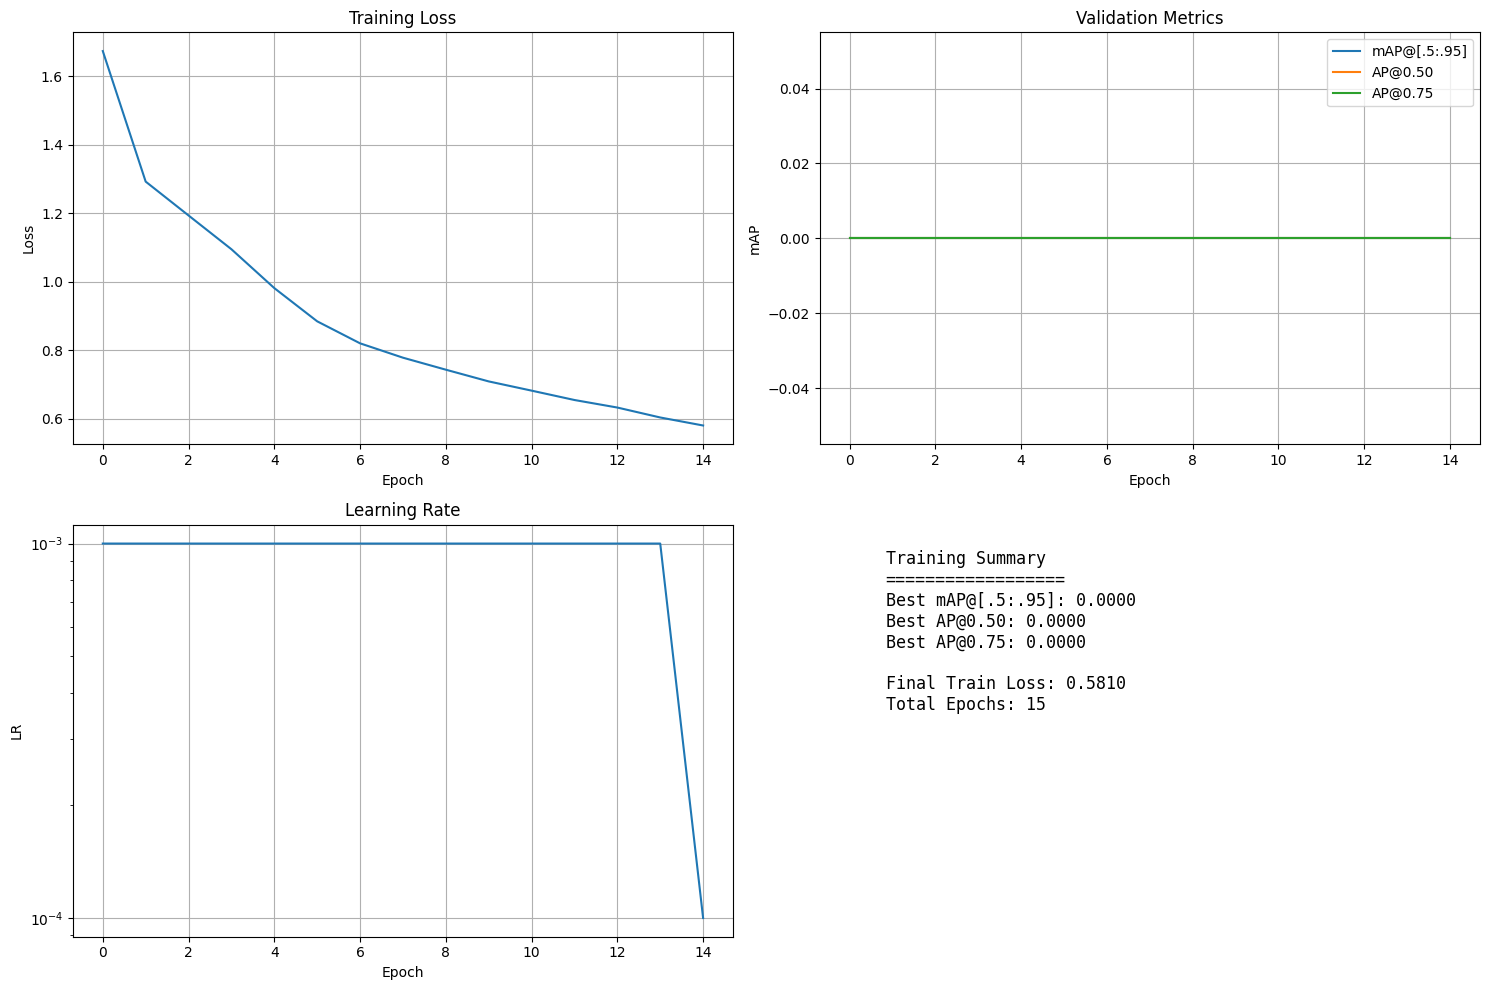

Training history plot saved to runs\rcnn\training_history.png


In [25]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training loss
axes[0, 0].plot(history['train_loss'])
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# mAP metrics
axes[0, 1].plot(history['val_map'], label='mAP@[.5:.95]')
axes[0, 1].plot(history['val_ap50'], label='AP@0.50')
axes[0, 1].plot(history['val_ap75'], label='AP@0.75')
axes[0, 1].set_title('Validation Metrics')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('mAP')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate
axes[1, 0].plot(history['lr'])
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('LR')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Summary text
summary_text = f"""Training Summary
==================
Best mAP@[.5:.95]: {best_map:.4f}
Best AP@0.50: {best_ap50:.4f}
Best AP@0.75: {best_ap75:.4f}

Final Train Loss: {history['train_loss'][-1]:.4f}
Total Epochs: {len(history['train_loss'])}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to {output_dir / 'training_history.png'}")